閉鎖性内湾を1つの水槽と見立てた場合の水質変化について検討したい．
今以下のような水質モデルを構築したとする．

(1)閉鎖性内湾の自浄作用を越える負荷はどのような時に発生するかを検討せよ
(2)モデルパラメータを変化させたときに，植物プランクトンの異常増殖が発生する
条件を検討せよ．
(3)夏季に高水温あるいは栄養塩制限を受けて，クロロフィル濃度が低下し，結果と
して，春と秋にブルームが観測される状況を再現せよ．
例として，東京湾の以下の数字を用いよ．
面積　体積　淡水流入量（平均値）

In [1]:
def O2_saturation(T):
    A1 = -173.4292
    A2 = 249.6339
    A3 = 143.3483
    A4 = -21.8492
    B1 = -0.033096
    B2 = 0.014259
    B3 = -0.0017000
    # Convert T to deg. C to deg. K
    T = T + 273.15
    # O2 Concentration in mg/l
    # [from Millero and Sohn, Chemical Oceanography, CRC Press, 1992]
    O = np.exp(A1 + A2*(100.0/T) + A3*np.log(T/100.0) + A4*(T/100.0))
    # Convert to mmol/m3
    #  mmol/m3 = 44.66 ml/l
    #  mg/l = ml/l * 1.42903 mg/ml

    return O * 1.42903

# 出水による栄養塩増加なし

100%|█████████████████████████████████████████████████████████████████████████| 17520/17520 [00:01<00:00, 13828.77it/s]


(0.0, 765.45)

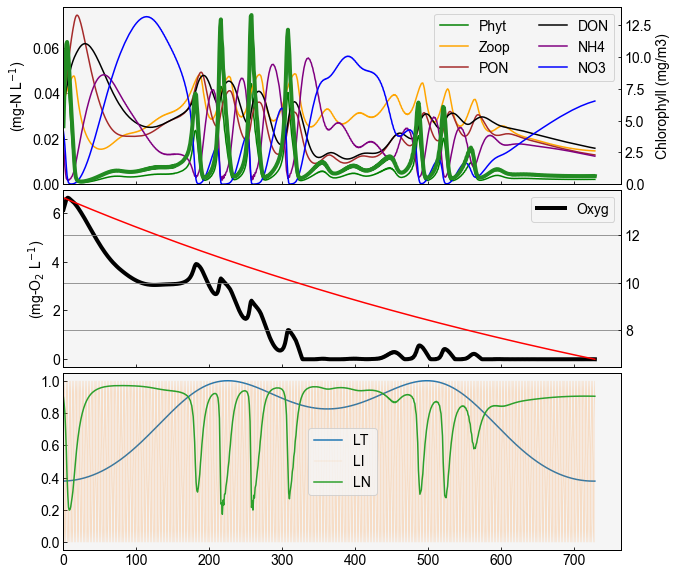

In [91]:
# %%writefile one_box_model_2022_v2.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=0.000001                        #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 6.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 25#最適水温
GR      = 3.                     #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.06    #水温依存20度における増殖速度；温度活性係数
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.05  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.05  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in tqdm(range(0, tmax)):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
#24時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
    LT = np.exp(-beta*(temp-temp_opt)**2)
    Vp = GR*LT

#     単調増加型
#     LT = np.exp(kvp*temp)
#     Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*Zoo_
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*PhyCN*mol2g_O2

#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.0 #7
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(10,10), sharex=True)

tax=ax.twinx()

ax.plot(bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(bio_log[:,2]*14/1000., label="Zoop", c="orange")
ax.plot(bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(bio_log[:,4]*14/1000., label="DON", c="k")
ax.plot(bio_log[:,5]*14/1000., label="NH4", c="purple")
ax.plot(bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(bio_log[:,7], label="Oxyg", lw=4, c="k")


ax2.twinx().plot(bio_log[:,8], label="TN", c="r")
# ax3.twinx().plot(frc_log[:,0], label="Tlimitation")

ax3.plot(frc_log[:,0], label="LT", )
ax3.plot(frc_log[:,1], label="LI", lw=0.1)
ax3.plot(frc_log[:,2], label="LN", ls='--')

ax.legend(ncol=2)
ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()
ax2.legend()
ax3.legend()
ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0)

In [11]:
%%writefile one_box_model_2022_fig1_v3.2.py

import numpy as np
import matplotlib.pyplot as plt
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=1e-07                      #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 12.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 25#最適水温
GR      = 3.                     #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.05    #水温依存20度における増殖速度；温度活性係数  kvp[0.06 >>0.03]
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.05  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.05  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in range(0, tmax):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

# calculate O2 100% at "temp"
    O2sat = O2_saturation(temp)
#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
# (output)時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
    LT = np.exp(-beta*(temp-temp_opt)**2)
    Vp = GR*LT

#     単調増加型
#     LT = np.exp(kvp*temp)
#     Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*max([Zoo_-ZooMin, 0.0])   #2024/02/16 修正 Zoo_ >> max([Zoo_-ZooMin, 0.0])
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*2.*mol2g_O2

# O2 aeration
    Oxyg += dt*0.03*(O2sat-Oxyg)
    
#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.0 #7
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

x = np.linspace(0,period, bio_log.shape[0])

fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(15,10), sharex=True)

tax=ax.twinx()

ax.plot(x, bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(x, bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(x, bio_log[:,2]*14/1000., label="Zoop", c="orange",ls="-.")
ax.plot(x, bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(x, bio_log[:,4]*14/1000., label="DON", c="k", ls="--")
ax.plot(x, bio_log[:,5]*14/1000., label="NH4", c="purple", ls=":")
ax.plot(x, bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(x, bio_log[:,7], label="Oxyg", lw=4, c="k")

tax2 = ax2.twinx()
tax2.plot(x, bio_log[:,8], label="TN", c="r", ls='--')
# ax3.twinx().plot(frc_log[:,0], label="Tlimitation")

ax3.plot(x, frc_log[:,0], label="LT", c='orange')
ax3.plot(x, frc_log[:,1], label="LI", lw=0.1, c='grey')
ax3.plot(x, frc_log[:,2], label="LN", c='b', ls='--')

ax.legend(ncol=1, bbox_to_anchor=(1.2,1), loc='upper right')
tax.legend(ncol=1, bbox_to_anchor=(1.2,0), loc='lower right')
ax2.legend(bbox_to_anchor=(1.2,0.), loc='lower right')
tax2.legend(bbox_to_anchor=(1.2,0.2), loc='lower right')
ax3.legend(bbox_to_anchor=(1.2,1), loc='upper right')

ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()

ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
tax2.set_ylabel("(mg-N L$^{-1}$)")
ax3.set_xlabel('(days from start)')

ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0,period)
plt.savefig('Fig5-27-1.png', dpi=350, bbox_inches='tight')

Writing one_box_model_2022_fig1_v3.2.py


In [12]:
%%writefile one_box_model_2022_fig2_v3.2.py

import numpy as np
import matplotlib.pyplot as plt
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=1e-07                      #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 12.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 25#最適水温
GR      = 3.                     #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.05    #水温依存20度における増殖速度；温度活性係数  kvp[0.06 >>0.03]
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.04  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.04  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in range(0, tmax):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

# calculate O2 100% at "temp"
    O2sat = O2_saturation(temp)
#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
#24時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
    LT = np.exp(-beta*(temp-temp_opt)**2)
    Vp = GR*LT

#     単調増加型
#     LT = np.exp(kvp*temp)
#     Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*max([Zoo_-ZooMin, 0.0])   #2024/02/16 修正 Zoo_ >> max([Zoo_-ZooMin, 0.0])
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*2.*mol2g_O2

# O2 aeration
    Oxyg += dt*0.03*(O2sat-Oxyg)
    
#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.0 #7
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

x = np.linspace(0,period, bio_log.shape[0])

fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(15,10), sharex=True)

tax=ax.twinx()

ax.plot(x, bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(x, bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(x, bio_log[:,2]*14/1000., label="Zoop", c="orange",ls="-.")
ax.plot(x, bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(x, bio_log[:,4]*14/1000., label="DON", c="k", ls="--")
ax.plot(x, bio_log[:,5]*14/1000., label="NH4", c="purple", ls=":")
ax.plot(x, bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(x, bio_log[:,7], label="Oxyg", lw=4, c="k")

tax2 = ax2.twinx()
tax2.plot(x, bio_log[:,8], label="TN", c="r", ls='--')
# ax3.twinx().plot(frc_log[:,0], label="Tlimitation")

ax3.plot(x, frc_log[:,0], label="LT", c='orange')
ax3.plot(x, frc_log[:,1], label="LI", lw=0.1, c='grey')
ax3.plot(x, frc_log[:,2], label="LN", c='b', ls='--')

ax.legend(ncol=1, bbox_to_anchor=(1.2,1), loc='upper right')
tax.legend(ncol=1, bbox_to_anchor=(1.2,0), loc='lower right')
ax2.legend(bbox_to_anchor=(1.2,0.), loc='lower right')
tax2.legend(bbox_to_anchor=(1.2,0.2), loc='lower right')
ax3.legend(bbox_to_anchor=(1.2,1), loc='upper right')

ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()

ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
tax2.set_ylabel("(mg-N L$^{-1}$)")
ax3.set_xlabel('(days from start)')

ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0,period)

plt.savefig('Fig5-27-2.png', dpi=350, bbox_inches='tight')

Writing one_box_model_2022_fig2_v3.2.py


In [13]:
%%writefile one_box_model_2022_fig3_v3.2.py

import numpy as np
import matplotlib.pyplot as plt
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=1e-07                      #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 12.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 20                     #最適水温
GR      = 3.                      #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.05    #水温依存20度における増殖速度；温度活性係数  kvp[0.06 >>0.03]
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.04  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.04  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in range(0, tmax):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
# calculate O2 100% at "temp"
    O2sat = O2_saturation(temp)
    
#24時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
    LT = np.exp(-beta*(temp-temp_opt)**2)
    Vp = GR*LT

#     単調増加型
#     LT = np.exp(kvp*temp)
#     Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*max([Zoo_-ZooMin, 0.0])   #2024/02/16 修正 Zoo_ >> max([Zoo_-ZooMin, 0.0])
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*2.*mol2g_O2

#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.0 #7
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# O2 aeration
    Oxyg += dt*0.03*(O2sat-Oxyg)
    
# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

x = np.linspace(0,period, bio_log.shape[0])

fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(15,10), sharex=True)

tax=ax.twinx()

ax.plot(x, bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(x, bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(x, bio_log[:,2]*14/1000., label="Zoop", c="orange",ls="-.")
ax.plot(x, bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(x, bio_log[:,4]*14/1000., label="DON", c="k", ls="--")
ax.plot(x, bio_log[:,5]*14/1000., label="NH4", c="purple", ls=":")
ax.plot(x, bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(x, bio_log[:,7], label="Oxyg", lw=4, c="k")

tax2 = ax2.twinx()
tax2.plot(x, bio_log[:,8], label="TN", c="r", ls='--')

ax3.plot(x, frc_log[:,0], label="LT", c='orange')
ax3.plot(x, frc_log[:,1], label="LI", lw=0.1, c='grey')
ax3.plot(x, frc_log[:,2], label="LN", c='b', ls='--')

ax.legend(ncol=1, bbox_to_anchor=(1.2,1), loc='upper right')
tax.legend(ncol=1, bbox_to_anchor=(1.2,0), loc='lower right')
ax2.legend(bbox_to_anchor=(1.2,0.), loc='lower right')
tax2.legend(bbox_to_anchor=(1.2,0.2), loc='lower right')
ax3.legend(bbox_to_anchor=(1.2,1), loc='upper right')

ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()

ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
tax2.set_ylabel("(mg-N L$^{-1}$)")
ax3.set_xlabel('(days from start)')

ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0,period)

plt.savefig('Fig5-27-3.png', dpi=350, bbox_inches='tight')

Writing one_box_model_2022_fig3_v3.2.py


In [14]:
%%writefile one_box_model_2022_fig4_v3.2.py

import numpy as np
import matplotlib.pyplot as plt
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=1e-07                      #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 12.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 20                     #最適水温
GR      = 3.                      #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.05    #水温依存20度における増殖速度；温度活性係数  kvp[0.06 >>0.03]
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.04  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.04  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in range(0, tmax):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
# calculate O2 100% at "temp"
    O2sat = O2_saturation(temp)
    
#24時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
#     LT = np.exp(-beta*(temp-temp_opt)**2)
#     Vp = GR*LT

#     単調増加型
    LT = np.exp(kvp*temp)
    Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*max([Zoo_-ZooMin, 0.0])   #2024/02/16 修正 Zoo_ >> max([Zoo_-ZooMin, 0.0])
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*2.*mol2g_O2

#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.0 #7
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# O2 aeration
    Oxyg += dt*0.03*(O2sat-Oxyg)
    
# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

x = np.linspace(0,period, bio_log.shape[0])

fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(15,10), sharex=True)

tax=ax.twinx()

ax.plot(x, bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(x, bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(x, bio_log[:,2]*14/1000., label="Zoop", c="orange",ls="-.")
ax.plot(x, bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(x, bio_log[:,4]*14/1000., label="DON", c="k", ls="--")
ax.plot(x, bio_log[:,5]*14/1000., label="NH4", c="purple", ls=":")
ax.plot(x, bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(x, bio_log[:,7], label="Oxyg", lw=4, c="k")

tax2 = ax2.twinx()
tax2.plot(x, bio_log[:,8], label="TN", c="r", ls='--')

# ax3.plot(x, frc_log[:,0], label="LT", c='orange')
ax3.plot(x, frc_log[:,1], label="LI", lw=0.1, c='grey')
ax3.plot(x, frc_log[:,2], label="LN", c='b', ls='--')

ax.legend(ncol=1, bbox_to_anchor=(1.2,1), loc='upper right')
tax.legend(ncol=1, bbox_to_anchor=(1.2,0), loc='lower right')
ax2.legend(bbox_to_anchor=(1.2,0.), loc='lower right')
tax2.legend(bbox_to_anchor=(1.2,0.2), loc='lower right')
ax3.legend(bbox_to_anchor=(1.2,1), loc='upper right')

ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()

ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
tax2.set_ylabel("(mg-N L$^{-1}$)")
ax3.set_xlabel('(days from start)')

ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0,period)

plt.savefig('Fig5-27-4.png', dpi=350, bbox_inches='tight')

Writing one_box_model_2022_fig4_v3.2.py


# 栄養塩増加あり

100%|█████████████████████████████████████████████████████████████████████████| 17520/17520 [00:01<00:00, 13899.47it/s]


(0.0, 765.45)

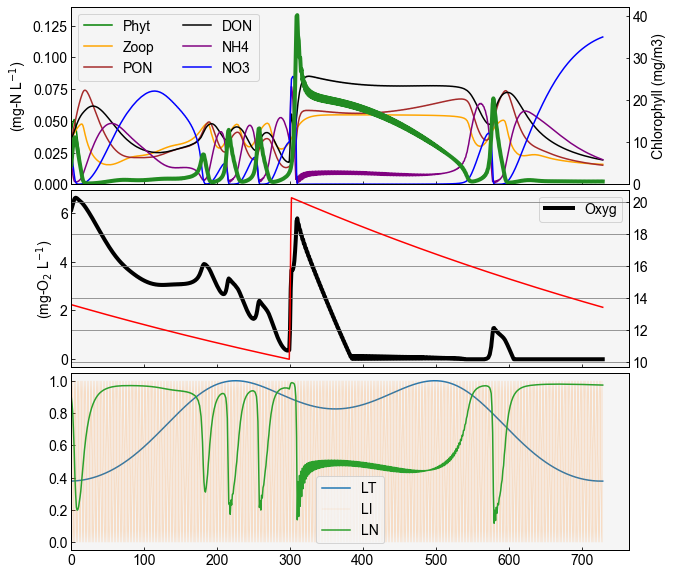

In [111]:
# %%writefile one_box_model_2022_v2.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
 

period = 365   #(day)
dt = 1800 /3600./24.  #(day)
eps=0.000001                        #ゼロ割防止

progress = 0
t_old = 0
day= 1.
output = 12
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   input init_values 
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#(mmol-N/m3)
Phyt = 2.5     #Var_1
Chla = 2   #Var_2
Zoo_ = 2.5     #Var_3
PON_ = 2.5     #Var_4
DON_ = 2.5     #Var_5

#(mmol-N/m3)
NH4_ = 1.8     #Var_6
NO3_ = 1.8     #Var_7

#(mmol-O2/m3)
Oxyg = 6.    #Var_8

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   set parameters
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
temp_opt = 25#最適水温
GR      = 3.                     #最適水温における増殖速度(最大増殖速度)
beta    = 0.003                   #最適水温　水温依存関数の尖度パラメータ
Vp20    = 1.5  ; kvp     =0.06    #水温依存20度における増殖速度；温度活性係数
a       =0.125                    #PIカーブの初期勾配
knh4    =0.714                    #光合成におけるNH4の半飽和定数
kno3    =0.714                    #光合成におけるNO3の半飽和定数
PhyMin = 0.001                    #植物プランクトンの最小値
ZooMin = 0.001                    #動物プランクトンの最小値
Gz20    =0.2   ; kgz     =0.003   #動物プランクトンの捕食速度；温度活性係数
kphy    =0.07                     #捕食に対する植物プランクトンの半飽和定数
Mz20    =0.05  ; kmz     =0.003   #動物プランクトンの枯死速度
Rp20    =0.05  ; krp     =0.03    #植物プランクトンの呼吸速度
Mp20    =0.05  ; kmp     =0.03    #植物プランクトンの枯死速度
Chl2C   =0.053                    #炭素クロロフィル重量比(単位変換用パラメータ)
Rpc20   =0.05  ; kpc     =0.06    #POMの加水分解速度；温度活性係数
Rdc20   =0.05  ; kdc     =0.06    #DOMの無機化速度；温度活性係数

PhyCN = 106/16.                   #植物プランクトンの炭素：窒素組成比(単位変換用パラメータ)
Rnit20  =0.05 ; knit    =0.01     #硝化速度；温度活性係数
mol2g_O2 = 0.032                  #溶存酸素(DO)単位変換用パラメータ
kdo = 0.3                         #DO依存性を考慮する際に使用する半飽和定数
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#プロット用ログ
bio_log = []
frc_log = []

tmax = round(period/dt)
for t in tqdm(range(0, tmax)):
#負の状態変数があればゼロに修正
    Phyt = np.max([Phyt, 0.0])
    Chla = np.max([Chla, 0.0])
    Zoo_ = np.max([Zoo_, 0.0])
    PON_ = np.max([PON_, 0.0])
    DON_ = np.max([DON_, 0.0])
    NH4_ = np.max([NH4_, 0.0])
    NO3_ = np.max([NO3_, 0.0])
    Oxyg = np.max([Oxyg, 0.0])
    TN   = Phyt + Zoo_ + PON_ + DON_ + NH4_ + NO3_
    
#水温の設定
    temp = 13* np.sin( (t*dt-90)*2*np.pi/365. )+20
#     temp = (np.sin( progress%day*2*np.pi/day )+1)*5 + 10

#日射量の設定(修正)
#     I = max( [(np.sin( (t*dt-90)*2*np.pi/365. )+2) , 0.0] ) * 150
#     I = ((np.sin(dt*t*24* np.pi/(24*365.) ) *350) *np.sin(dt*t*2*np.pi))
    I=((np.sin((t*dt-90)* 2*np.pi/(365.) ) *280)+480 )*np.sin(t*dt*2*np.pi)
    I = np.where(I<0, 0, I)
    
#24時間ごとに抽出
    if (round(progress*24./output)!=round(t_old*24./output)): 
        bio_log.append([Phyt, Chla, Zoo_, PON_, DON_, NH4_, NO3_, Oxyg, TN])
        frc_log.append([LT, LI, Ltot,])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   calculation biochemical term
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#Photosynthesis
#     最適水温型増殖
    LT = np.exp(-beta*(temp-temp_opt)**2)
    Vp = GR*LT

#     単調増加型
#     LT = np.exp(kvp*temp)
#     Vp = Vp20*LT
    
    LI = a*I/np.sqrt(a*a*I*I + Vp*Vp)
    Lnh4 =  NH4_/(NH4_+knh4)
    Lno3 = NO3_/(NO3_+kno3) * knh4/(NH4_+knh4)
    Ltot = max([Lnh4+Lno3, eps])
    
    fac = dt*Vp*LI*Ltot*Phyt
    fac1= fac*Lnh4/max([Ltot,eps]) /max([NH4_,eps])
    fac2= fac*Lno3/max([Ltot,eps]) /max([NO3_,eps])
    
#     NH4_ -= fac1
#     NO3_ -= fac2
    NH4_ /= (1.0 + fac1)
    NO3_ /= (1.0 + fac2)
    cff1 = fac1 * NH4_
    cff2 = fac2 * NO3_
    
    Phyt += cff1+cff2
    Chla += (Chl2C*PhyCN*12)*(cff1+cff2)
    Oxyg += mol2g_O2*(cff1*PhyCN + cff2*(PhyCN+2))

#Phytoplankton >> Zooplankton
    Phyt2 = Phyt*Phyt
    Gz = Gz20*np.exp(kgz*temp)*max([Zoo_-ZooMin, 0])*(Phyt/(kphy+Phyt2))
    fac = dt*Gz*max([Phyt-PhyMin, 0])
#     cff = 1.0/(1.0 + fac)
    Chla -= fac*Chla/max([Phyt-PhyMin, 0.0])
    Phyt -= fac
    Zoo_ += fac
#     Phyt *= cff
#     Chla *= cff
    
#Phytoplankton >> PON
#Zooplankton >> PON
    Mz = dt*Mz20*np.exp(kmz*temp)
    Mp = dt*Mp20*np.exp(kmp*temp)
    cff1 = Mz*Zoo_
    cff2 = Mp*max([Phyt-PhyMin, 0.0])
    PON_ += cff1*Zoo_ + cff2
    Zoo_ -= cff1*Zoo_
#     Zoo_ = Zoo_/(1.0+cff1)
    Phyt -= cff2
    Chla -= Mp*Chla
    
    
# Phytoplankton >> DON
    Rp = dt*Rp20*np.exp(krp*temp)
    cff = Rp*max([Phyt-PhyMin, 0.0])
    Phyt -= cff
    Chla -= Rp*Chla
    DON_ += cff
    Oxyg -= cff*PhyCN*mol2g_O2
    
# Remineralization
# DON_ >> NH4_
    Rdc= dt*Rdc20*np.exp(kdc*temp)
#     DOC_ /= (1.0+Rdc)
    NH4_ += Rdc*DON_
    DON_ -= Rdc*DON_
    Oxyg -= Rdc*DON_*PhyCN*mol2g_O2

#Decomposition
# PON_ >> DON_
    Rpc= dt*Rpc20*np.exp(kpc*temp)
    DON_ += Rpc*PON_
    PON_ -= Rpc*PON_

# Nitrification
    Rnit = dt*Rnit20*np.exp(knit*temp)
    NO3_ += Rnit*NH4_
    NH4_ -= Rnit*NH4_
    Oxyg -= Rnit*NH4_*PhyCN*mol2g_O2

#[  ]  <<<  inflow
    timestep_inflow = [150]
#     timestep_inflow = [50,100,250, 310]
    inflow = 0.07
    if (int(progress) in timestep_inflow):
        DON_ += inflow
        NO3_ += inflow
        NH4_ += inflow
        Oxyg += inflow

# outflow <<< [ ]
    out = 0.00004
#     out *= np.sin(dt*t*2*np.pi)
    Phyt -= Phyt*out
    Chla -= Chla*out
    Zoo_ -= Zoo_*out
    PON_ -= PON_*out
    DON_ -= DON_*out
    NH4_ -= NH4_*out
    NO3_ -= NO3_*out
    Oxyg -= Oxyg*out

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   update variables
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    t_old = progress
    progress+=dt
    
#     TOC    = Phyt +Zoo_ +POC_ +DOC_

bio_log = np.array(bio_log)
frc_log = np.array(frc_log)

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#   plot
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(10,10), sharex=True)

tax=ax.twinx()

ax.plot(bio_log[:,0]*14/1000., label="Phyt", c="green")
tax.plot(bio_log[:,1], label="Chla", c="forestgreen", lw=4)
ax.plot(bio_log[:,2]*14/1000., label="Zoop", c="orange")
ax.plot(bio_log[:,3]*14/1000., label="PON", c="brown")
ax.plot(bio_log[:,4]*14/1000., label="DON", c="k")
ax.plot(bio_log[:,5]*14/1000., label="NH4", c="purple")
ax.plot(bio_log[:,6]*14/1000., label="NO3", c="blue")

ax2.plot(bio_log[:,7], label="Oxyg", lw=4, c="k")


ax2.twinx().plot(bio_log[:,8], label="TN", c="r")
# ax3.twinx().plot(frc_log[:,0], label="Tlimitation")

ax3.plot(frc_log[:,0], label="LT", )
ax3.plot(frc_log[:,1], label="LI", lw=0.1)
ax3.plot(frc_log[:,2], label="LN", c='b', ls='--')

ax.legend(ncol=2)
ax.grid()
tax.grid(False)
ax2.grid()
ax3.grid()
ax2.legend()
ax3.legend()
ax.set_ylabel("(mg-N L$^{-1}$)")
tax.set_ylabel("Chlorophyll (mg/m3)")
ax2.set_ylabel("(mg-O$_2$ L$^{-1}$)")
ax.set_ylim(0,)
tax.set_ylim(0)
ax.set_xlim(0)

# 日射入力の確認

(0.0, 1000.0)

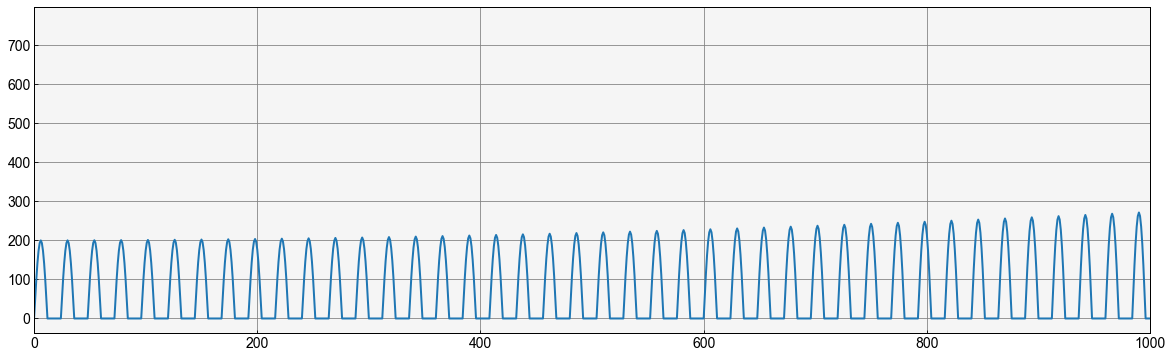

In [115]:
x=np.arange(0,24*365)
y = ((np.sin((x-90*24)* 2*np.pi/(24*365.) ) *(480-200))+480 )*np.sin(x*2*np.pi/24.)
y = np.where(y<0, 0, y)

fig,ax = plt.subplots(figsize=(20,6))
ax.plot(x,y, lw=2,)
# ax.set_xlim(120*24,150*24)
ax.set_xlim(0,1000)

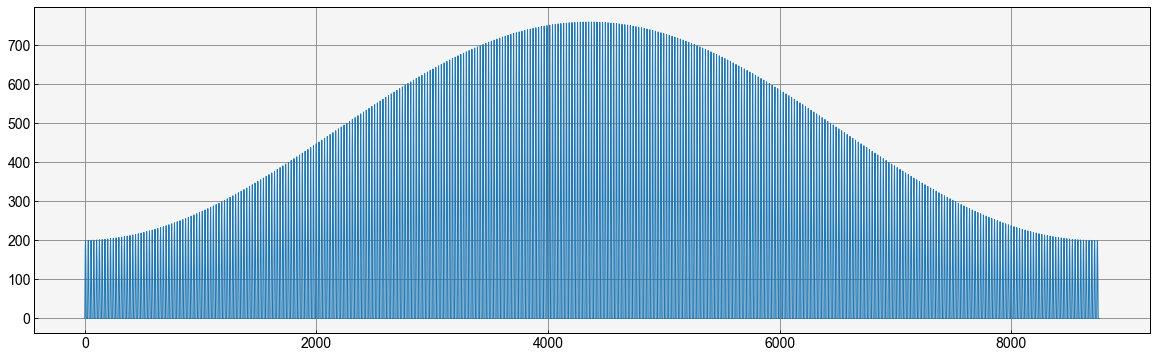

In [117]:
fig,ax = plt.subplots(figsize=(20,6))
ax.plot(x,y, lw=1)
# ax.set_xlim(120*24,150*24)